In [2]:
import logging

# 设置关键库的日志级别
loggers_to_quiet = [
    'httpx',           # HTTP 客户端库
    'httpcore',        # HTTP 核心库
    'urllib3',         # HTTP 客户端库
    'requests',        # HTTP 客户端库
    'openai',          # OpenAI API 库
    'torch',           # PyTorch
    'transformers',    # Hugging Face Transformers
    'langchain',       # LangChain
    'langchain_core',  # LangChain Core
    'tqdm',           # 进度条库
    'numba',          # Numba
    'matplotlib',      # Matplotlib
]

for logger_name in loggers_to_quiet:
    logging.getLogger(logger_name).setLevel(logging.WARNING)

# 如果还有调试信息，可以设置根日志记录器的级别
logging.getLogger().setLevel(logging.WARNING)

In [3]:
import sys
sys.path.append('/root/autodl-tmp/I-AM/project/backend/agents')

from langchain_openai import ChatOpenAI
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, ToolMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables import Runnable, RunnableConfig
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import AnyMessage, add_messages
from typing import TypedDict, Annotated, Literal, NotRequired, List, Optional, Any
from pydantic import BaseModel, Field, ConfigDict, field_validator


import uuid
import os
from dotenv import load_dotenv

load_dotenv()

True

In [4]:
def add_log(current_log, new_log: str) -> list[str]:
    if current_log is None:
        return [new_log] if isinstance(new_log, str) else new_log
    elif isinstance(current_log, list):
        return current_log + [new_log] if isinstance(new_log, str) else new_log
    elif isinstance(current_log, str):
        return [current_log, new_log] if isinstance(new_log, str) else new_log
    else:
        return [new_log] if isinstance(new_log, str) else new_log

class OverallState(BaseModel):
    messages: Annotated[List[AnyMessage], add_messages] = Field(default_factory=list, title="对话列表")
    route: Literal["affirmation", "meditation", "normal_chat"] = Field(default="normal_chat", title="当前路由")
    log: Annotated[List[str], add_log] = Field(default_factory=list, title="日志列表")

    model_config = ConfigDict(arbitrary_types_allowed=True)

    @field_validator('log', mode='before')
    def validate_log(cls, v, info):
        if v is None or (isinstance(v, list) and len(v) == 0):
            return []
        if 'log' in info.data:
            return add_log(info.data['log'], v)
        return [v] if isinstance(v ,str) else v
        

    @field_validator('messages', mode='before')
    def validate_messages(cls, v, info):
        if 'messages' in info.data:
            return add_messages(info.data['messages'], v)
        else:
            return v if isinstance(v, list) else [v]


## 肯定语模块

In [5]:
from affirmation_agent import AffirmationAgent

config_path = '/root/autodl-tmp/I-AM/project/backend/config/affirmation.yaml'

affirmation_agent = AffirmationAgent(config_path).create_graph()


## 冥想模块

In [6]:
def create_meditation(state: OverallState) -> OverallState:
    return {"route": "meditation", "log": "冥想音频已生成"}

meditation_workflow = StateGraph(OverallState)
meditation_workflow.add_node("create_meditation", create_meditation)
meditation_workflow.add_edge(START, "create_meditation")
meditation_workflow.add_edge("create_meditation", END)

meditation_agent = meditation_workflow.compile()

# from meditation_agent import create_meditation_graph

# meditation_agent = create_meditation_graph()


In [7]:
llm = ChatOpenAI(model="deepseek-chat", openai_api_key=os.getenv("DEEPSEEK_API_KEY"), openai_api_base='https://api.deepseek.com')

## 用户反馈

In [8]:
def user_feadback_agent(state: OverallState) -> OverallState:
    if state.route == "affirmation":
        user_approval = input("是否打开肯定语？(yes/no):")
        if user_approval.lower() == "yes":
            return {"route": "affirmation", "log": "用户同意打开肯定语"}
        else:
            return {"route": "normal_chat", "log": "用户不同意打开肯定语"}
    elif state.route == "meditation":
        user_approval = input("是否打开冥想音频？(yes/no):")
        if user_approval.lower() == "yes":
            return {"route": "meditation", "log": "用户同意打开冥想音频"}
        else:
            return {"route": "normal_chat", "log": "用户不同意打开冥想音频"}

## 路由

In [9]:
class Router(TypedDict):
    route: Literal["affirmation", "meditation", "normal_chat"]

with open('../prompts/router_prompt.txt', 'r') as file:
    router_prompt = file.read().strip()

router_model = llm.with_structured_output(Router)

def router_node(state: OverallState) -> OverallState:    
    messages = [SystemMessage(content=router_prompt)] + state.messages
    route = router_model.invoke(messages)
    return {"route": route["route"], "log": "路由已确定"}



## 主对话模块

In [10]:
with open('../prompts/chat_prompt.txt', 'r') as file:
    chat_prompt = file.read().strip()

normal_system_prompt = ChatPromptTemplate(
    [
        SystemMessage(content=chat_prompt),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

def normal_chat_agent(state: OverallState) -> OverallState:
    prompt = normal_system_prompt.partial(route=state.route, log="\n".join(state.log))
    print(prompt)
    normal_llm = prompt | llm
    response = normal_llm.invoke(state.messages)
    return {"route": "normal_chat", "messages": [response], "log": "常规对话已生成"}


## 构建图

In [11]:
def router_condition_edge(state: OverallState):
    if state.route == "affirmation" or state.route == "meditation":
        return "user_feadback_agent"
    elif state.route == "normal_chat":
        return "normal_chat_agent"
    
def user_feadback_condition_edge(state: OverallState):
    if state.route == "affirmation":
        return "affirmation_agent"
    elif state.route == "meditation":
        return "meditation_agent"
    else:
        return "normal_chat_agent"

main_dialogue_workflow = StateGraph(OverallState)
main_dialogue_workflow.add_node("router_node", router_node)
main_dialogue_workflow.add_node("user_feadback_agent", user_feadback_agent)
main_dialogue_workflow.add_node("normal_chat_agent", normal_chat_agent)
main_dialogue_workflow.add_node("affirmation_agent", affirmation_agent)
main_dialogue_workflow.add_node("meditation_agent", meditation_agent)

main_dialogue_workflow.add_conditional_edges(
    "router_node",
    router_condition_edge,
    {
        "user_feadback_agent": "user_feadback_agent",
        "normal_chat_agent": "normal_chat_agent"
    }
)

main_dialogue_workflow.add_conditional_edges(
    "user_feadback_agent",
    user_feadback_condition_edge,
    {
        "affirmation_agent": "affirmation_agent",
        "meditation_agent": "meditation_agent",
        "normal_chat_agent": "normal_chat_agent"
    }
)
main_dialogue_workflow.add_edge("affirmation_agent", "normal_chat_agent")
main_dialogue_workflow.add_edge("meditation_agent", "normal_chat_agent")
main_dialogue_workflow.add_edge(START, "router_node")
main_dialogue_workflow.add_edge("normal_chat_agent", END)


memory = MemorySaver()
main_dialogue_graph = main_dialogue_workflow.compile(checkpointer=memory)

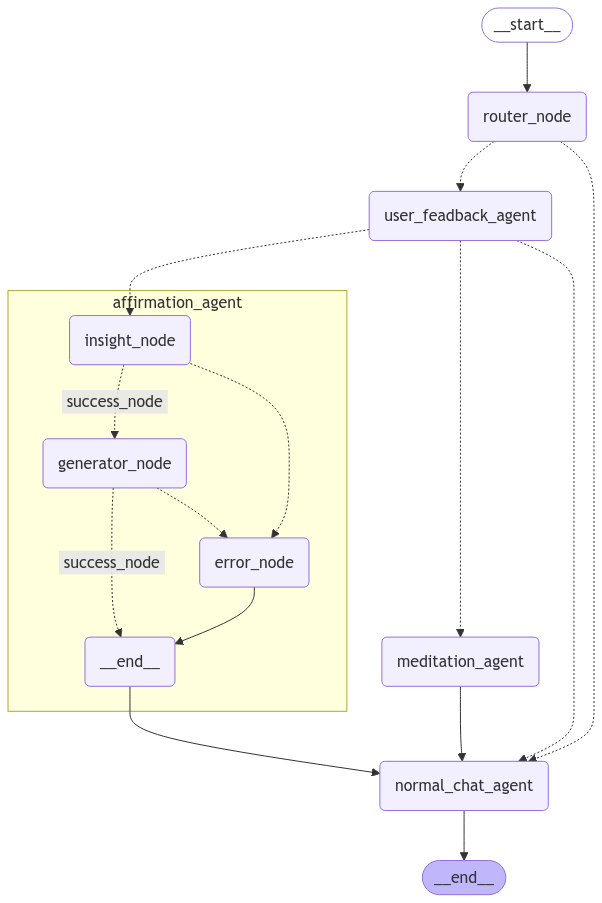

In [12]:
from IPython.display import Image, display

# Setting xray to 1 will show the internal structure of the nested graph
display(Image(main_dialogue_graph.get_graph(xray=2).draw_mermaid_png()))

In [13]:
config = {"configurable": {"thread_id": "001"}}

In [14]:
inputs = {"messages": [HumanMessage(content="我计划明天向我喜欢的男生表白了，帮我生成几条肯定语，加强我的信心")]}
for chunk in main_dialogue_graph.stream(inputs, config=config):
    print(chunk)

# state = main_dialogue_graph.get_state(config)
# if state.next:
#     if state.next[0] == "diary_agent":
#         user_approval = input("是否打开显化日记本？(yes/no):")
#         if user_approval.lower() == "yes":
#             for chunk in main_dialogue_graph.stream(None, config=config, stream_mode="messages"):
#                 print(chunk[0].content, end="")
#     elif state.next[0] == "meditation_agent":
#         user_approval = input("是否打开冥想音频？(yes/no):")
#         if user_approval.lower() == "yes":
#             for chunk in main_dialogue_graph.stream(None, config=config, stream_mode="messages"):
#                 print(chunk[0].content, end="")

In [14]:
# for state in main_dialogue_graph.get_state_history(config):
#     print(state.values[''])

In [15]:
# import logging

# # 列出所有当前的 loggers
# for name, logger in logging.root.manager.loggerDict.items():
#     print(f"Logger name: {name}")
#     if isinstance(logger, logging.Logger):
#         print(f"  Level: {logger.level}")
#         print(f"  Handlers: {logger.handlers}")
#         print(f"  Parent: {logger.parent}")
#     print("---")

# # 然后根据发现的 logger 名称设置级别
# # 例如，如果发现是 'api_client' 在输出这些日志：
# # logging.getLogger('api_client').setLevel(logging.WARNING)

## 对话存储

In [16]:
# conversation_json = {
#     "messages": []
# }

# for d in chunk['messages']:
#     if type(d).__name__ == 'HumanMessage':
#         item = {"role": "user", "content": d.content}
#     elif type(d).__name__ == 'AIMessage':
#         item = {"role": "assistant", "content": d.content}
#     else:
#         continue
#     conversation_json['messages'].append(item)


In [17]:
# import json

# with open('conversations_data/affirmations.json', 'w', encoding='utf-8') as f:
#     json.dump(conversation_json, f, indent=2, ensure_ascii=False)